# 训练图像分类器

## 1. 加载和标准化CIFAR10
使用torchvision，加载CIFAR10非常容易。

In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms

torchvision数据集的输出是范围[0,1]的PILImage图像。我们将它们转换为归一化范围的张量[-1,1]。  
从https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 下载，存放至 ../data/cifar-10-python.tar.gz

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


展示一些训练图像

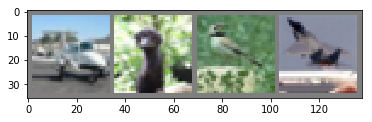

plane  bird  bird plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2.定义卷积神经网络
从神经网络部分复制神经网络并修改它以获取3通道图像（而不是定义的1通道图像）。

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3.定义Loss函数和优化器
让我们使用分类交叉熵损失和SGD动量。

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4.培训网络
事情开始变得有趣了。我们只需循环遍历数据迭代器，并将输入提供给网络并进行优化。

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.277
[1,  4000] loss: 1.954
[1,  6000] loss: 1.721
[1,  8000] loss: 1.619
[1, 10000] loss: 1.556
[1, 12000] loss: 1.512
[2,  2000] loss: 1.450
[2,  4000] loss: 1.417
[2,  6000] loss: 1.399
[2,  8000] loss: 1.387
[2, 10000] loss: 1.339
[2, 12000] loss: 1.315
Finished Training


## 5.在测试数据上测试网络
我们已经在训练数据集上训练了2次epoch。但我们需要检查网络是否已经学到了什么。  

我们将通过预测神经网络输出的类标签来检查这一点，并根据地面实况进行检查。如果预测正确，我们将样本添加到正确预测列表中。

好的，第一步。让我们从测试集中显示一个图像以熟悉。

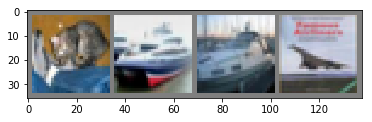

GroundTruth:    cat  ship  ship plane


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

好的，现在让我们看看神经网络认为上面这些例子是什么：

In [8]:
outputs = net(images)

输出是10类的能量。一个类的能量越高，网络认为图像是特定类的越多。那么，让我们得到最高能量的指数：

In [9]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


结果似乎很好。

让我们看看网络如何在整个数据集上执行。

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


看起来好于机会，这是10％的准确性（从10个班级中随机挑选一个班级）。似乎网络学到了一些东西。

嗯，什么是表现良好的类，以及表现不佳的类：

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 54 %
Accuracy of   car : 69 %
Accuracy of  bird : 32 %
Accuracy of   cat : 39 %
Accuracy of  deer : 53 %
Accuracy of   dog : 27 %
Accuracy of  frog : 70 %
Accuracy of horse : 57 %
Accuracy of  ship : 83 %
Accuracy of truck : 52 %


## 6.在GPU上进行培训  
就像你将Tensor转移到GPU上一样，你将神经网络转移到GPU上。

如果我们有可用的CUDA，我们首先将我们的设备定义为第一个可见的cuda设备：


In [12]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


本节的其余部分假定这device是一个CUDA设备。

然后这些方法将递归遍历所有模块并将其参数和缓冲区转换为CUDA张量：   
`net.to(device)`   
请记住，您还必须将每一步的输入和目标发送到GPU：

`inputs, labels = inputs.to(device), labels.to(device)`   
